In [13]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# Load the cats vs dogs dataset
(train_ds, validation_ds), info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    with_info=True,
    as_supervised=True,
)

/Users/julien/fhcw-aie/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]Corrupt JPEG data: 239 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 128 extraneous bytes before marker 0xd9
Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9
Corrupt JPEG data: 396 extraneous bytes before marker 0xd9
Corrupt JPEG data: 228 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9
Corrupt JPEG data: 65 extraneous bytes before marker 0xd9
                                                                        

Dataset cats_vs_dogs downloaded and prepared to /Users/julien/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
# Print information about the dataset
print('Dataset info:')
print(f'Number of training examples: {info.splits["train"].num_examples}')
print('\nFeatures:')
print(info.features)

Dataset info:
Number of training examples: 23262

Features:
FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'image/filename': Text(shape=(), dtype=string),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=2),
})


In [8]:
# Data preprocessing
IMG_SIZE = 160

def preprocess(image, label):
    # Resize the image
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    # Normalize pixel values
    image = image / 255.0
    return image, label

BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Apply preprocessing to both datasets
train_ds = train_ds.map(preprocess, num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(preprocess, num_parallel_calls=AUTOTUNE)

# Configure datasets for performance
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(AUTOTUNE)
validation_ds = validation_ds.cache().batch(BATCH_SIZE).prefetch(AUTOTUNE)

In [9]:
# Create the CNN model
model = tf.keras.Sequential([
    # First convolutional block
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    tf.keras.layers.MaxPooling2D(),
    
    # Second convolutional block
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Third convolutional block
    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    
    # Dense layers
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')  # Binary classification (cat or dog)
])

# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy']
)

# Display model summary
model.summary()

/Users/julien/fhcw-aie/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 158, 158, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 79, 79, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 77, 77, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 36, 36, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 20736)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     1,327,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,383,553 (5.28 MB)

 Trainable params: 1,383,553 (5.28 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Train the model
epochs = 3
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    verbose=1
)

Epoch 1/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 127s 218ms/step - accuracy: 0.7405 - loss: 0.5258 - val_accuracy: 0.7896 - val_loss: 0.4597
Epoch 2/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 204s 351ms/step - accuracy: 0.7895 - loss: 0.4482 - val_accuracy: 0.7997 - val_loss: 0.4385
Epoch 3/3
582/582 ━━━━━━━━━━━━━━━━━━━━ 219s 377ms/step - accuracy: 0.8246 - loss: 0.3937 - val_accuracy: 0.8222 - val_loss: 0.3999


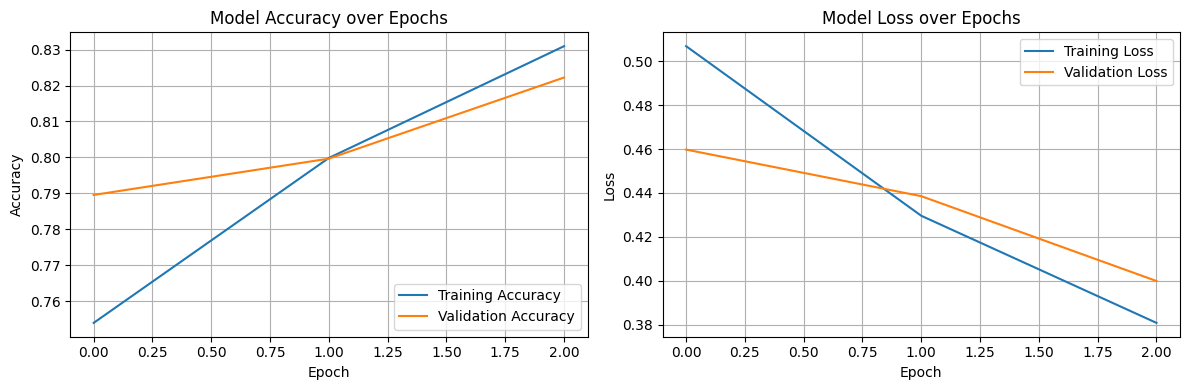


Final Training Metrics:
Training Accuracy: 0.8310
Validation Accuracy: 0.8222
Training Loss: 0.3809
Validation Loss: 0.3999


In [17]:
# Plot training history
plt.figure(figsize=(12, 4))

# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print final metrics
print('\nFinal Training Metrics:')
print(f'Training Accuracy: {history.history["accuracy"][-1]:.4f}')
print(f'Validation Accuracy: {history.history["val_accuracy"][-1]:.4f}')
print(f'Training Loss: {history.history["loss"][-1]:.4f}')
print(f'Validation Loss: {history.history["val_loss"][-1]:.4f}')

Sample predictions on validation dataset:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


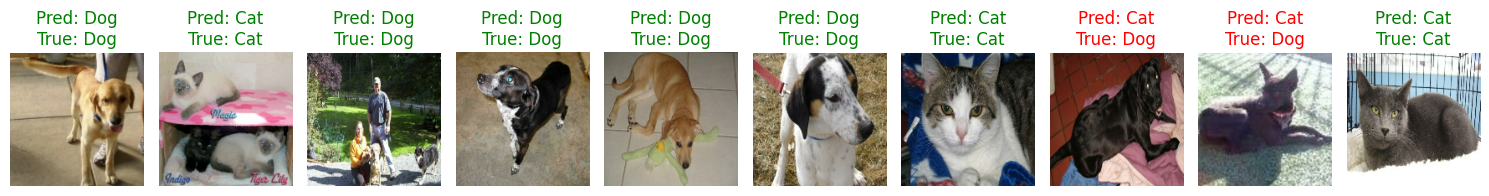

In [19]:
# Visualize some predictions
def plot_predictions(dataset, num_images=5):
    # Get a batch of images
    images, labels = next(iter(dataset.unbatch().batch(num_images)))
    
    # Make predictions
    predictions = model.predict(images)
    
    # Plot the images and predictions
    plt.figure(figsize=(15, 3))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(images[i])
        pred_label = "Dog" if predictions[i] > 0.5 else "Cat"
        true_label = "Dog" if labels[i] == 1 else "Cat"
        color = 'green' if pred_label == true_label else 'red'
        plt.title(f'Pred: {pred_label}\nTrue: {true_label}', color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize predictions on validation dataset
print("Sample predictions on validation dataset:")
plot_predictions(validation_ds, 10)